<h1>Graph Embedding</h1>

<h2>Imports</h2>

In [1]:
import collections
from functools import wraps
import math
import matplotlib.animation as animation 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from pymongo import MongoClient
import tensorflow as tf
import time

%matplotlib inline

<h2>HyperParameters</h2>

In [29]:
sentence_count = 3000
sentence_length = 1000 
path_length = 10
batch_size = 6
embedding_size = 3
num_sampled = 12
skip_window = 2
num_steps = 1000001
learning_rate = 0.1
p = 1
q = 0.5

<h2>Loading Training Data From Previous Runs (Optional)</h2>

In [3]:
with open('./reversed_dictionary', 'rb') as f:
        reversed_dictionary = pickle.load(f)
with open('./dictionary', 'rb') as f:
        dictionary = pickle.load(f)
with open('./counts', 'rb') as f:
        counts = pickle.load(f)
with open('./coded_counts', 'rb') as f:
        coded_counts = pickle.load(f)

<h2>Database Connection</h2>

In [4]:
mongo_client = MongoClient("db:27017")
db = mongo_client.rumi

<h2>Utility Functions</h2>

<h3>Measures runtime of functions</h3>

In [5]:
def timer(orig_func):
    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t0 = time.time()
        result = orig_func(*args, **kwargs)
        t = time.time() - t0
        print('{} ran in: {} sec'.format(orig_func.__name__, t))
        return result
    return wrapper

<h3>Prints input and output of all functions</h3>

In [6]:
def debug(func):
    @wraps(func)
    def wrapper_debug(*args, **kwargs):
        args_repr = [repr(a) for a in args]
        kwargs_repr = [f"{k}={v!r}" for k, v in kwargs.items()]
        signature = ", ".join(args_repr + kwargs_repr)
        print(f"Calling {func.__name__}({signature})")
        value = func(*args, **kwargs)
        print(f"{func.__name__!r} returned {value!r}")
        return value
    return wrapper_debug

<h2>Calulating Frequencies</h2>

In [7]:
db.user_follower.update_many({}, {'$set': {'read': '0', 'encoded': '0', 'graph': '0','visited': '0'}})
db.graph.drop()
docs = db.user_follower.find({'read': '0'}, {'user_id': 1, 'follower_user_id': 1})
counts = collections.Counter()
for doc in docs: 
    counts[doc['user_id']] += 1
    counts[doc['follower_user_id']] += 1
    db.user_follower.update_one({'_id': doc['_id']}, {'$set': {'read': '1'}})
with open('./counts', 'wb') as file:
    pickle.dump(counts, file)

<h2>Integer Encoding</h2>

In [10]:
dictionary = {}
for code, count in enumerate(counts.most_common()):
    dictionary[count[0]] = code
coded_counts = collections.Counter()
for i, j in counts.items():
    coded_counts[dictionary[i]] = j
with open('./coded_counts', 'wb') as file:
    pickle.dump(coded_counts, file)
with open('./dictionary', 'wb') as file:
    pickle.dump(dictionary, file)
reversed_dictionary = {v: k for k, v in dictionary.items()}
with open('./reversed_dictionary', 'wb') as file:
    pickle.dump(reversed_dictionary, file)

<h2>Transforming Input</h2>

In [9]:
docs = db.user_follower.find({'read': '1', 'encoded': '0'}, {'user_id': 1, 'follower_user_id': 1})
for doc in docs: 
    db.user_follower.update_one({'_id': doc['_id']}, 
            {'$set': {'encoded': '1','coded_user_id': dictionary[doc['user_id']],
             'coded_follower_user_id': dictionary[doc['follower_user_id']]}})

<h2>Graph Generation</h2>

In [10]:
docs = db.user_follower.find({'encoded': '1', 'graph': '0'}, {'coded_user_id': 1, 'coded_follower_user_id': 1}, batch_size=10)
for doc in docs: 
    db.follower_graph.update_one({'user_id': doc['coded_user_id']}, 
        {'$push': {'followers': doc['coded_follower_user_id']}}, upsert=True)
    db.user_follower.update_one({'_id': doc['_id']}, {'$set': {'graph': '1'}}) 

<h2>Evaluating the Dataset</h2>

<h3>Word Frequencies</h3>

Text(0.5, 1.0, 'PDF in loglog scale')

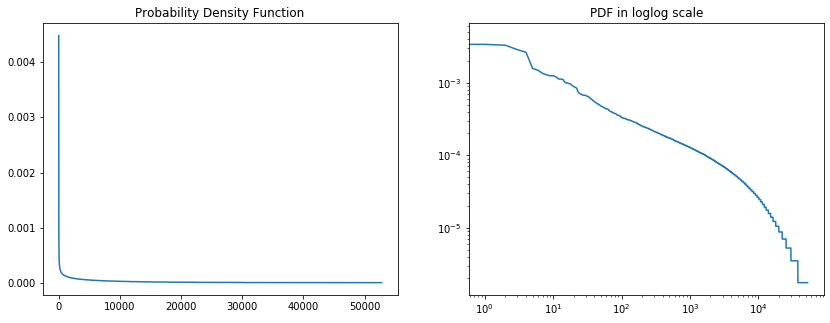

In [6]:
x_data = [i for i in reversed_dictionary.keys()]
total_counts = sum(counts.values())
pdfs = {i:j/total_counts for (i,j) in counts.items()}
y_data = [pdfs[reversed_dictionary[i]] for i in x_data]
fig, ax = plt.subplots(1, 2, figsize=[14,5])
ax[0].plot(x_data, y_data)
ax[0].set_title('Probability Density Function')
ax[1].loglog(x_data, y_data)
ax[1].set_title('PDF in loglog scale')

<h2>Performing Walk</h2>

<h3>Defining Random Walk<h3>

In [5]:
def node2vec_walk(db, doc, path_length):
    path = np.ones(path_length, dtype=int) * (-1)
    path[0] = doc['coded_user_id']
    path[1] = doc['coded_follower_user_id']
    for i in range(2, path_length): 
        options = db.follower_graph.find_one({'user_id': path[i-1].item()}, {'_id': 0, 'followers': 1})
        if options is None:
            while path[-1] == -1:
                path = np.delete(path, -1)
            return path
        else:
            options = options['followers']
            weights = np.empty_like(options)
            for index, option in enumerate(options): 
                if option == path[i-1]: 
                    weights[index] = 1/p
                else: 
                    weights[index] = 1/q
            path[i] = np.random.choice(options, 1, p=weights/np.sum(weights))      
    return path

In [6]:
def pseudo_random_walk(db, doc, path_length):
    path = np.ones(path_length, dtype=int) * (-1)
    path[0] = doc['coded_user_id']
    path[1] = doc['coded_follower_user_id']
    for i in range(2, path_length): 
        options = db.follower_graph.find_one({'user_id': path[i-1].item()}, {'_id': 0, 'followers': 1})
        if options is None:
            while path[-1] == -1:
                path = np.delete(path, -1)
            return path
        else:
            options = options['followers']
            weights = np.empty_like(options)
            for index, option in enumerate(options): 
                weights[index] = coded_counts[option]
            path[i] = np.random.choice(options, 1, p=weights/np.sum(weights)) 
    return path

In [7]:
docs = db.user_follower.find({'graph': '1', 'visited': '0'}, {'coded_user_id': 1, 'coded_follower_user_id': 1}, batch_size=10)
for doc in docs: 
    path = node2vec_walk(db, doc, path_length)
    db.node2vec_paths.insert_one({'path': path.tolist()})
    path = pseudo_random_walk(db, doc, path_length)
    db.pseudo_random_paths.insert_one({'path': path.tolist()})
    db.user_follower.update_one({'_id': doc['_id']}, {'$set': {'visited': '1'}})

<h2>Creating Batch Generator</h2> 

In [17]:
class batch_generator:
    def __init__(self, db, db_batch_size, skip_window, batch_size, mode):
        self.db_batch_size = db_batch_size
        self.db = db
        self.skip_window = skip_window
        self.path_index = 0
        self.word_index = 0
        self.mode = mode
        self.batch_size = batch_size
        self.collection = getattr(db, self.mode)
        self.paths = self.collection.find({}, batch_size=self.db_batch_size)
        self.paths_count = self.collection.count_documents

    def __get_path(self):
        path = self.paths[self.path_index]
        path = path['path']
        path_length = len(path)
        return path, path_length

    def generate_batch(self):
        batch = np.zeros([self.batch_size], dtype=int)
        labels = np.zeros([self.batch_size, 1], dtype=int)
        path, path_length = self.__get_path()
        for batch_index in range(self.batch_size):
            batch[batch_index] = path[self.word_index]
            label_choices = list(range(max(0 , self.word_index - self.skip_window), min(path_length, self.word_index + self.skip_window + 1)))
            label_choices.remove(self.word_index)
            labels[batch_index] = path[np.random.choice(label_choices, 1).item()]
            self.word_index += 1
            if self.word_index == path_length:
                self.word_index = 0
                self.path_index += 1
                if self.path_index == self.paths_count: 
                    self.path_index = 0
                    self.paths = self.self.collection.find({}, batch_size=self.db_batch_size)
                path, path_length = self.__get_path()
        return batch, labels 
generator = batch_generator(db=db, db_batch_size=5, skip_window=skip_window, batch_size=batch_size, mode="node2vec_paths")

<h2>Creating the Computational Graph</h2> 

In [18]:
graph = tf.Graph()
vocabulary_size = len(dictionary)
with graph.as_default():
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    with tf.device('/cpu:0'):
        with tf.name_scope('embeddings'):
            embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        with tf.name_scope('weights'):
            nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                                    stddev=1.0 / math.sqrt(embedding_size)))
        with tf.name_scope('biases'):
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=train_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size))
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    init = tf.global_variables_initializer()

<h2>Training the Network</h2>

<h3>Starting the session

In [30]:
with tf.Session(graph=graph) as session: 
#     saver.restore(sess, "/tmp/model.ckpt")
#     with open('./generator', 'rb') as f:
#         generator = pickle.load(f)
    init.run()
    print('Initialized')
    average_loss = 0
    loss_sum = 0
    losses =[]
    steps = []
    for step in range(num_steps):
#         save_path = saver.save(sess, "/tmp/model.ckpt")
#         with open("./main/generator", 'wb') as file: 
#             pickle.dump(generator, file)
        batch_inputs, batch_labels = generator.generate_batch()
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        loss_sum += loss_val
        if step % 1000 == 0: 
            average_loss = loss_sum / 1000
            loss_sum = 0
            losses.append(average_loss)
            steps.append(step)

Initialized


KeyboardInterrupt: 

<h2>Evaluating the Training</h2>

Text(0.5, 1.0, 'Loss Value')

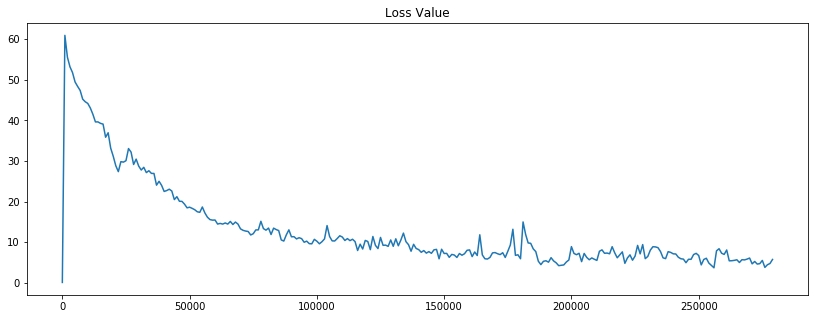

In [31]:
fig, ax = plt.subplots(1, 1, figsize=[14,5])
ax.plot(steps, losses)
ax.set_title('Loss Value')